# PySpark - Работа с RDD (Resilient Distributed Datasets)

## Введение в RDD
RDD (Resilient Distributed Datasets) - это основная абстракция в Apache Spark. RDD представляет собой неизменяемую распределенную коллекцию объектов, которая может обрабатываться параллельно. В этом ноутбуке мы рассмотрим основные концепции и операции с RDD в PySpark.

## Содержание
1. Инициализация Spark и создание SparkContext
2. Создание RDD
3. Базовые операции с RDD
4. Трансформации RDD
5. Actions (действия) над RDD
6. Парные RDD и операции с ключами
7. Сохранение и загрузка RDD
8. Практические примеры

## 1. Инициализация Spark и создание SparkContext

In [ ]:
!pip install findspark numpy matplotlib pandas

In [ ]:
import findspark
findspark.init()

In [ ]:
# Импорт необходимых библиотек

from pyspark import SparkConf, SparkContext
import os
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Создание SparkConf и SparkContext
conf = SparkConf().setAppName("RDD Practice").setMaster("local[*]")
sc = SparkContext(conf=conf)

# Проверка версии Spark
print(f"Spark Version: {sc.version}")

## 2. Создание RDD
Существует несколько способов создания RDD в Spark:

### Создание RDD из коллекции Python

In [ ]:
# Создание RDD из Python-списка
data = [1, 2, 3, 4, 5]
rdd = sc.parallelize(data)
print(f"RDD: {rdd}")
print(f"RDD Content: {rdd.collect()}")

### Создание RDD из внешних файлов

In [ ]:
# Создадим текстовый файл для примера
!echo "Hello Spark" > example.txt
!echo "RDD is fundamental abstraction in Spark" >> example.txt
!echo "It represents a resilient distributed dataset" >> example.txt
# если выполняем на кластере, то используем hdfs
!hdfs dfs -ls /user
!hdfs dfs -mkdir -p /user/ubuntu
!hadoop fs -put -f example.txt /user/ubuntu/example.txt

In [ ]:
# Создание RDD из текстового файла
text_rdd = sc.textFile("example.txt")
print(f"Text RDD Content: {text_rdd.collect()}")

### Создание RDD с определенным числом партиций

In [ ]:
# Создание RDD с 4 партициями
data_partitioned = sc.parallelize(range(10), 4)
print(f"Number of partitions: {data_partitioned.getNumPartitions()}")
print(f"Partitioned RDD content: {data_partitioned.collect()}")
print(f"Partitioned RDD glom: {data_partitioned.glom().collect()}")

## 3. Базовые операции с RDD

### Информация об RDD

In [ ]:
# Получение информации о партициях
num_partitions = rdd.getNumPartitions()
print(f"Number of partitions: {num_partitions}")

# Оценка размера RDD
print(f"RDD count: {rdd.count()}")

# Просмотр содержимого партиций с помощью glom()
print(f"Content of each partition: {rdd.glom().collect()}")

## 4. Трансформации RDD
Трансформации создают новый RDD из существующего. Они являются "ленивыми", то есть вычисляются только при вызове действия.

### map() - применение функции к каждому элементу


In [ ]:
# Применение функции map для возведения в квадрат
squared_rdd = rdd.map(lambda x: x**2)
print(f"Original RDD: {rdd.collect()}")
print(f"Squared RDD: {squared_rdd.collect()}")

### filter() - фильтрация элементов по условию

In [ ]:
# Фильтрация четных чисел
even_rdd = rdd.filter(lambda x: x % 2 == 0)
print(f"Original RDD: {rdd.collect()}")
print(f"Even numbers only: {even_rdd.collect()}")

### flatMap() - генерация 0 или более выходных элементов из каждого входного

In [ ]:
# Разделение строк на слова с помощью flatMap
words_rdd = text_rdd.flatMap(lambda line: line.split())
print(f"Original text RDD: {text_rdd.collect()}")
print(f"Words RDD (after flatMap): {words_rdd.collect()}")

### distinct() - удаление дубликатов

In [16]:
# Создание RDD с дубликатами
dup_data = [1, 2, 2, 3, 3, 3, 4, 5, 5]
dup_rdd = sc.parallelize(dup_data)

In [17]:
# Получение уникальных элементов
distinct_rdd = dup_rdd.distinct()
print(f"RDD with duplicates: {dup_rdd.collect()}")
print(f"RDD after distinct(): {distinct_rdd.collect()}")

RDD with duplicates: [1, 2, 2, 3, 3, 3, 4, 5, 5]
RDD after distinct(): [4, 1, 5, 2, 3]


### sample() - выборка элементов

In [18]:
# Выборка с заменой
sample_with_replacement = rdd.sample(True, 0.5, seed=42)
print(f"Sample with replacement: {sample_with_replacement.collect()}")

Sample with replacement: [4]


In [19]:
# Выборка без замены
sample_without_replacement = rdd.sample(False, 0.5, seed=42)
print(f"Sample without replacement: {sample_without_replacement.collect()}")

Sample without replacement: [1]


### union(), intersection(), subtract() - теоретико-множественные операции

In [20]:
# Создание второго RDD
rdd2 = sc.parallelize([3, 4, 5, 6, 7])

In [21]:
# Объединение RDD
union_rdd = rdd.union(rdd2)
print(f"RDD1: {rdd.collect()}")
print(f"RDD2: {rdd2.collect()}")
print(f"Union: {union_rdd.collect()}")


RDD1: [1, 2, 3, 4, 5]
RDD2: [3, 4, 5, 6, 7]
Union: [1, 2, 3, 4, 5, 3, 4, 5, 6, 7]


In [22]:
# Пересечение RDD
intersection_rdd = rdd.intersection(rdd2)
print(f"Intersection: {intersection_rdd.collect()}")


Intersection: [3, 4, 5]


In [23]:
# Разность RDD
subtract_rdd = rdd.subtract(rdd2)
print(f"RDD1 - RDD2: {subtract_rdd.collect()}")


RDD1 - RDD2: [1, 2]



## 5. Actions (действия) над RDD
Действия возвращают значения из RDD в программу драйвера или записывают их во внешнюю систему хранения. Они запускают вычисления.

### collect() - получение всех элементов



In [24]:
# Сбор всех элементов RDD в драйвер
collected_data = rdd.collect()
print(f"Collected data: {collected_data}")

Collected data: [1, 2, 3, 4, 5]


### count() - подсчет элементов


In [25]:
# Подсчет количества элементов
count = rdd.count()
print(f"Count: {count}")

Count: 5


### first() - получение первого элемента


In [26]:
# Получение первого элемента
first_element = rdd.first()
print(f"First element: {first_element}")


First element: 1


### take(n) - получение n элементов

In [27]:
# Получение первых n элементов
first_3 = rdd.take(3)
print(f"First 3 elements: {first_3}")


First 3 elements: [1, 2, 3]


### reduce() - агрегирование элементов

In [28]:
# Сумма всех элементов с помощью reduce
sum_of_elements = rdd.reduce(lambda a, b: a + b)
print(f"Sum of all elements: {sum_of_elements}")

# Произведение всех элементов
product_of_elements = rdd.reduce(lambda a, b: a * b)
print(f"Product of all elements: {product_of_elements}")

Sum of all elements: 15
Product of all elements: 120


### foreach() - выполнение действия для каждого элемента

In [29]:
# Вывод каждого элемента (в логи исполнителей, не в драйвер)
rdd.foreach(lambda x: print(f"Element: {x}"))

## 6. Парные RDD и операции с ключами
Парные RDD - это RDD, элементами которого являются пары (ключ, значение). Они поддерживают особые операции, такие как groupByKey, reduceByKey и др.

### Создание парного RDD



In [30]:
# Создание парного RDD
pairs = [("a", 1), ("b", 2), ("a", 3), ("c", 4), ("b", 5), ("c", 6)]
pairs_rdd = sc.parallelize(pairs)
print(f"Pairs RDD: {pairs_rdd.collect()}")

Pairs RDD: [('a', 1), ('b', 2), ('a', 3), ('c', 4), ('b', 5), ('c', 6)]


### reduceByKey() - агрегирование значений по ключу

In [31]:
# Суммирование значений по ключу
sums_by_key = pairs_rdd.reduceByKey(lambda a, b: a + b)
print(f"Sum by key: {sums_by_key.collect()}")

Sum by key: [('b', 7), ('c', 10), ('a', 4)]


### groupByKey() - группировка значений по ключу

In [32]:
# Группировка значений по ключу
grouped_by_key = pairs_rdd.groupByKey().mapValues(list)
print(f"Grouped by key: {grouped_by_key.collect()}")

Grouped by key: [('b', [2, 5]), ('c', [4, 6]), ('a', [1, 3])]


### sortByKey() - сортировка по ключу

In [33]:
# Сортировка по ключу
sorted_by_key = pairs_rdd.sortByKey()
print(f"Sorted by key: {sorted_by_key.collect()}")

# Сортировка по ключу в обратном порядке
sorted_by_key_desc = pairs_rdd.sortByKey(ascending=False)
print(f"Sorted by key (descending): {sorted_by_key_desc.collect()}")

Sorted by key: [('a', 1), ('a', 3), ('b', 2), ('b', 5), ('c', 4), ('c', 6)]
Sorted by key (descending): [('c', 4), ('c', 6), ('b', 2), ('b', 5), ('a', 1), ('a', 3)]


### join() - соединение парных RDD

In [34]:
# Создание второго парного RDD
pairs2 = [("a", "apple"), ("b", "banana"), ("c", "cherry")]
pairs_rdd2 = sc.parallelize(pairs2)

In [35]:
# Внутреннее соединение
joined_rdd = pairs_rdd.join(pairs_rdd2)
print(f"RDD1: {pairs_rdd.collect()}")
print(f"RDD2: {pairs_rdd2.collect()}")
print(f"Joined RDD: {joined_rdd.collect()}")

RDD1: [('a', 1), ('b', 2), ('a', 3), ('c', 4), ('b', 5), ('c', 6)]
RDD2: [('a', 'apple'), ('b', 'banana'), ('c', 'cherry')]
Joined RDD: [('a', (1, 'apple')), ('a', (3, 'apple')), ('b', (2, 'banana')), ('b', (5, 'banana')), ('c', (4, 'cherry')), ('c', (6, 'cherry'))]


In [36]:
# Левое внешнее соединение
left_joined = pairs_rdd.leftOuterJoin(pairs_rdd2)
print(f"Left joined: {left_joined.collect()}")

Left joined: [('a', (1, 'apple')), ('a', (3, 'apple')), ('b', (2, 'banana')), ('b', (5, 'banana')), ('c', (4, 'cherry')), ('c', (6, 'cherry'))]


In [37]:
# Правое внешнее соединение
right_joined = pairs_rdd.rightOuterJoin(pairs_rdd2)
print(f"Right joined: {right_joined.collect()}")

Right joined: [('a', (1, 'apple')), ('a', (3, 'apple')), ('b', (2, 'banana')), ('b', (5, 'banana')), ('c', (4, 'cherry')), ('c', (6, 'cherry'))]


## 7. Сохранение и загрузка RDD

### Сохранение в текстовый файл



In [39]:
# Сохранение RDD в текстовый файл
sums_by_key.saveAsTextFile("key_sums.txt")

In [42]:
# Просмотр сохраненных файлов
!ls -l key_sums

ls: cannot access 'key_sums': No such file or directory


In [ ]:
# Просмотр содержимого сохраненных файлов
!cat key_sums/part-*

In [ ]:
# Удаление созданных файлов
!rm -rf key_sums/
!rm example.txt

## 8. Практические примеры

### Пример 1: Подсчет слов в тексте

In [43]:
# Создадим текстовый файл с примером текста
text = """
Apache Spark is an open-source unified analytics engine for large-scale data processing.
Spark provides an interface for programming entire clusters with implicit data parallelism and fault tolerance.
Originally developed at the University of California, Berkeley's AMPLab, the Spark codebase was later donated to the Apache Software Foundation, which has maintained it since.
Spark provides an interface for programming entire clusters with implicit data parallelism and fault tolerance.
"""

with open("spark_text.txt", "w") as f:
    f.write(text)

In [44]:
!hadoop fs -put -f spark_text.txt /user/ubuntu/spark_text.txt

Количество слов в тексте:
spark: 4
an: 3
for: 3
data: 3
the: 3
provides: 2
programming: 2
entire: 2
clusters: 2
implicit: 2
fault: 2
tolerance: 2
apache: 2
interface: 2
with: 2
parallelism: 2
and: 2
is: 1
open-source: 1
unified: 1
analytics: 1
engine: 1
originally: 1
developed: 1
at: 1
university: 1
of: 1
codebase: 1
was: 1
large-scale: 1
processing: 1
california: 1
berkeley's: 1
amplab: 1
later: 1
donated: 1
to: 1
software: 1
foundation: 1
which: 1
has: 1
maintained: 1
it: 1
since: 1


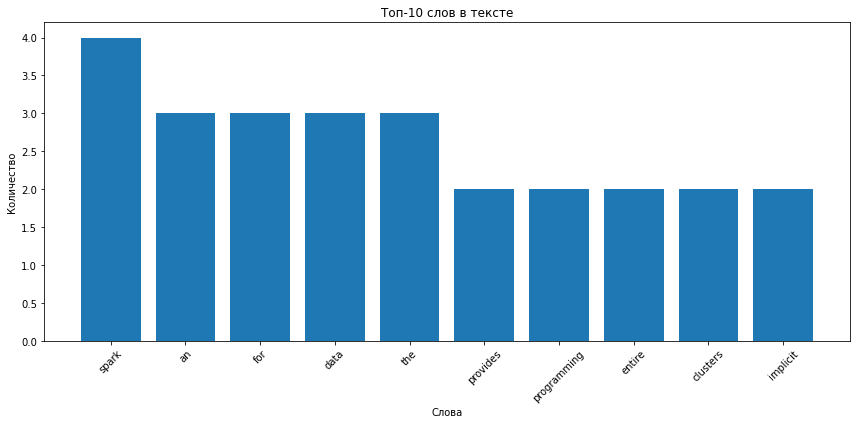

In [45]:
# Загрузка текста в RDD
text_rdd = sc.textFile("spark_text.txt")

# Подсчет слов (классическая задача WordCount)
word_counts = (text_rdd
    .flatMap(lambda line: line.split())
    .map(lambda word: (word.lower().strip(".,;:\"\'()[]{}"), 1))
    .reduceByKey(lambda a, b: a + b)
    .sortBy(lambda x: x[1], ascending=False)
)


print("Количество слов в тексте:")
for word, count in word_counts.collect():
    print(f"{word}: {count}")

# Визуализация топ-10 слов
top_10_words = word_counts.take(10)
words = [word for word, count in top_10_words]
counts = [count for word, count in top_10_words]

plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xlabel('Слова')
plt.ylabel('Количество')
plt.title('Топ-10 слов в тексте')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Пример 2: Оценка числа π методом Монте-Карло

Оценка числа π методом Монте-Карло: 3.142372
Истинное значение π: 3.141592653589793
Погрешность: 0.000779346410206827


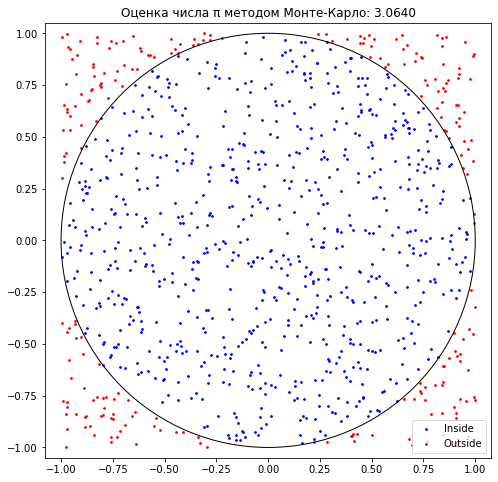

In [46]:
def inside_circle(p):
    """Проверяет, находится ли точка p внутри единичной окружности"""
    x, y = p
    return x*x + y*y < 1

# Число точек для оценки
num_samples = 1000000

# Генерация случайных точек
samples = sc.parallelize([
    (random.uniform(-1, 1), random.uniform(-1, 1)) 
    for _ in range(num_samples)
])

# Подсчет точек внутри окружности
count_inside = samples.filter(inside_circle).count()

# Оценка числа π
pi_estimate = 4.0 * count_inside / num_samples

print(f"Оценка числа π методом Монте-Карло: {pi_estimate}")
print(f"Истинное значение π: {np.pi}")
print(f"Погрешность: {abs(pi_estimate - np.pi)}")

# Визуализация метода Монте-Карло (на меньшем числе точек)
visualize_samples = 1000
points = [(random.uniform(-1, 1), random.uniform(-1, 1)) for _ in range(visualize_samples)]
inside = [p for p in points if inside_circle(p)]
outside = [p for p in points if not inside_circle(p)]

plt.figure(figsize=(8, 8))
plt.scatter([p[0] for p in inside], [p[1] for p in inside], color='blue', s=3, label='Inside')
plt.scatter([p[0] for p in outside], [p[1] for p in outside], color='red', s=3, label='Outside')
circle = plt.Circle((0, 0), 1, fill=False, color='black')
plt.gca().add_patch(circle)
plt.axis('equal')
plt.xlim(-1.05, 1.05)
plt.ylim(-1.05, 1.05)
plt.legend()
plt.title(f'Оценка числа π методом Монте-Карло: {4.0 * len(inside) / visualize_samples:.4f}')
plt.show()



In [47]:
# Очистка после работы
!rm spark_text.txt

In [49]:
# Остановка SparkContext
sc.stop()

print("RDD практика завершена!")

RDD практика завершена!
